## Visualize and analyse results from synthetic data experiments

In [1]:
import math, time
import torch
import os
import sys
sys.path.append('../..')
from functions.get_data import data_n_loaders
import matplotlib.pyplot as plt

In [2]:
#get exptnames from folder names within saved_models
def get_exptnames():
    exptnames = []
    for root, dirs, files in os.walk('saved_models'):
        for dir in dirs:
            if 'checkpoints_' in dir:
                exptnames.append(dir.split('checkpoints_')[1])
    #sort exptnames to have all with same sae_type (name after the first _ within exptnames) together; after saename, the float following must be used for sorting
    order = {'relu': 0, 'jumprelu': 1, 'spade': 3, 'topk': 2}
    exptnames = sorted(exptnames, key=lambda x: (order[x.split('_')[1]]))
    return exptnames

In [ ]:
#get sae_types from expt_names: it will be the string after first _, except for spade, which should be repaced by sparsemax_dist
def get_sae_types(exptnames):
    sae_types = []
    for exptname in exptnames:
        if 'spade' in exptname:
            sae_types.append('sparsemax_dist')
        elif 'topk_relu' in exptname:
            sae_types.append('topk_relu')
        elif 'jumprelu' in exptname:
            sae_types.append('jumprelu')
        elif 'relu' in exptname:
            sae_types.append('relu')
        # else:
        #     sae_types.append(exptname.split('_')[1])
    return sae_types

In [4]:
exptnames = get_exptnames()
#sort exptnames by using the number after k whenever topk is used
exptnames = sorted(exptnames, key=lambda x: (int(x.split('_')[3].split('k')[1]) if 'topk' in x else 0))

In [5]:
saetypes = get_sae_types(exptnames)

In [ ]:
kvals_all = [int(exptname.split('_')[3].split('k')[1]) if 'topk' in exptname else 0 for exptname in exptnames]
from models import SAE
dim = 128

import numpy as np

device = 'cuda'
modelsall = []
mseall = []
regall = []
mseperconceptall = []
width = 512 #standard in this expt set
for i in range(len(exptnames)):
    exptnamei = exptnames[i]
    normalize_decoder = False if saetypes[i] == 'sparsemax_dist' else True
    modeli = SAE(dim, width, sae_type=saetypes[i],kval_topk=kvals_all[i], normalize_decoder=normalize_decoder)
    state_dict = torch.load(f"./saved_models/checkpoints_{exptnamei}/model_10938epochs.pt")
    modeli.load_state_dict(state_dict['model'])
    modelsall.append(modeli.to(device))
    losses = torch.load(f"./saved_models/checkpoints_{exptnamei}/losses.pt")
    losses = losses['train_loss']
    mse = np.nansum([losses[-1*i][0].item() for i in range(1, 11)])/10
    reg = np.nansum([losses[-1*i][1].item() for i in range(1, 11)])/10
    lossperconcept = torch.stack(tuple([losses[-1*i][2].detach() for i in range(1, 11)]), dim=0).nansum(dim=0)/10
    mseall.append(mse)
    regall.append(reg)
    mseperconceptall.append(lossperconcept)

/tmp/ipykernel_749592/720855486.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"./saved_models/checkpoints_{exptnamei}/model_10938epochs.pt")


In [10]:
ind = saetypes.index('sparsemax_dist')

losses_spmax = torch.load(f"./saved_models/checkpoints_{exptnames[ind]}/losses.pt")

/tmp/ipykernel_749592/1067889059.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  losses_spmax = torch.load(f"./saved_models/checkpoints_{exptnames[ind]}/losses.pt")


Text(0.5, 1.0, 'isotropic, low var')

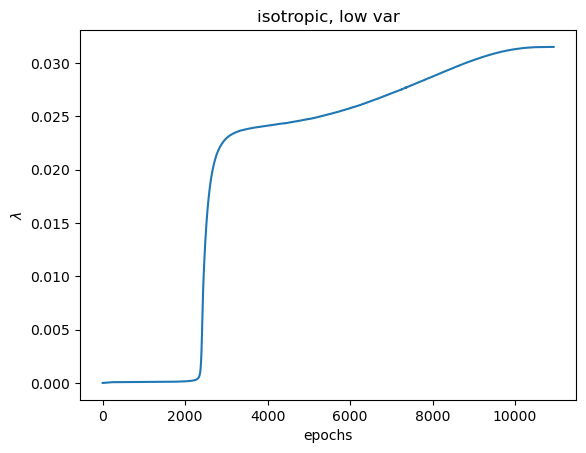

In [11]:
plt.plot([losses_spmax['lambda'][i].cpu() for i in range(len(losses_spmax['lambda']))])
plt.ylabel(r'$\lambda$')
plt.xlabel('epochs')
plt.title("isotropic, low var")

In [12]:
LAB_DIR = os.environ['USERDIR']
DATA_PATH = LAB_DIR+'/data'

In [13]:
meannorm2_concepts_all = []
dataset = f'128dgaussianclustersiso'
batchsize = 512
_,_,train_data, _ = data_n_loaders(dataset, batchsize, return_data=True, \
                                    data_path=DATA_PATH, standardise_data = True)
#sample equal number of points from each class
numpoints_perconcept = 1000
num_concepts = 5
data_subset_perconcept = []
labels_subset_perconcept = []
for j in range(num_concepts):
    indices = train_data.labels == j
    rand_indices_i = torch.randperm(indices.sum())[:numpoints_perconcept]
    data_subset_perconcept.append(train_data.data[indices][rand_indices_i])
    labels_subset_perconcept.append(train_data.labels[indices][rand_indices_i])
    data_subset = torch.cat(data_subset_perconcept, dim=0)
    labels_subset = torch.cat(labels_subset_perconcept, dim=0)
for i in range(len(exptnames)):
    with torch.no_grad():
        meannorm2_concepts = torch.stack([torch.mean(torch.norm(data_subset[labels_subset==j,:], dim=1)**2) for j in range(num_concepts)])
        meannorm2_concepts_all.append(meannorm2_concepts)

/n/home00/sumedh/spmax_sae/experiments/expt8_intrinsicdim3/../../functions/get_data.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  file = torch.load(datapath)


In [14]:
concept_intrinsicdims = train_data.truefeatures['intrinsic_dims']

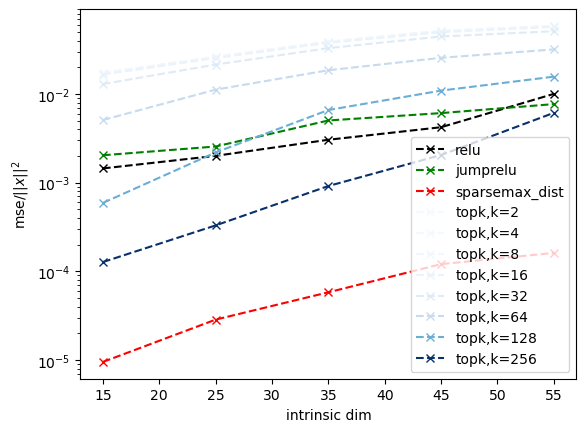

In [15]:
#assign a set of colors to relu, topk, spade, and for topk, assign color from cmap indicating k value with intensity
colors = {'relu': 'k', 'jumprelu': 'green', 'sparsemax_dist': 'red'}
cmap = plt.get_cmap('Blues')
kvals_topk = [k for k in kvals_all if k>0]
topk_colors = [cmap(k / max(kvals_all)) for k in kvals_topk]


for i in range(len(exptnames)):
    if 'topk' in exptnames[i]:
        label = f"topk,k={kvals_all[i]}"
        #color index same as order of kvals_all
        khere = kvals_all[i]
        #index of khere in kvals_topk
        ind_khere = kvals_topk.index(khere)
        color = topk_colors[ind_khere]
    else:
        label = saetypes[i]
        color = colors[saetypes[i]]
    sortorder = np.argsort(concept_intrinsicdims)
    plt.plot(concept_intrinsicdims[sortorder], mseperconceptall[i].cpu()[sortorder]/meannorm2_concepts_all[i][sortorder], \
        label=label, linestyle='dashed', marker='x', color=color)
plt.xlabel('intrinsic dim')
plt.ylabel(r"mse/$||x||^2$")
plt.legend()
plt.yscale('log')

In [16]:
latent_reps_all = []
preds_all = []
Cdatacos = []
stableranks = []
from functions.utils import stable_rank

for i in range(len(exptnames)):
    modeli = modelsall[i]
    with torch.no_grad():
        pred, latent_reps = modeli(data_subset.to(device), return_hidden=True)
        latent_reps_all.append(latent_reps.cpu())
        preds_all.append(pred.cpu())
        Cdata = latent_reps @ latent_reps.T
        
        norms = torch.norm(latent_reps, dim=1).unsqueeze(1)
        Cdatacos.append(Cdata/(norms @ norms.T + 1e-12))
        sr = stable_rank(Cdatacos[i])
        stableranks.append(sr.cpu().item())

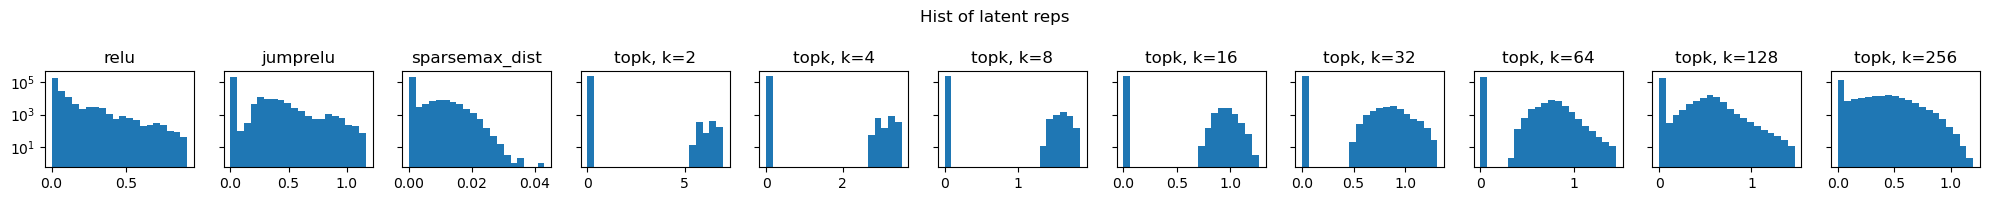

In [17]:
fig, ax = plt.subplots(1, len(exptnames), figsize=(20,2), sharey=True)
torch.manual_seed(0)
for i in range(len(exptnames)):
    indices = torch.randperm(latent_reps_all[i].shape[0])[:500]
    ax[i].hist(latent_reps_all[i][indices,:].flatten(), bins=20)
    title = f"{saetypes[i]}"
    if 'topk' in exptnames[i]:
        title += f", k={kvals_all[i]}"
    ax[i].set_title(title)
    ax[i].set_yscale('log')
fig.suptitle("Hist of latent reps")
fig.tight_layout()

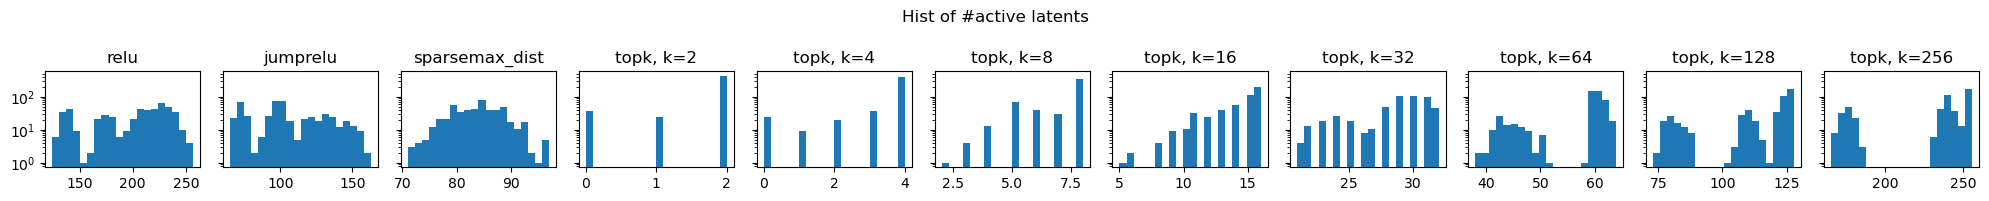

In [79]:
fig, ax = plt.subplots(1, len(exptnames), figsize=(20,2), sharey=True)
torch.manual_seed(0)
activelatentdist_all = []
for i in range(len(exptnames)):
    indices = torch.randperm(latent_reps_all[i].shape[0])[:500]
    latents = latent_reps_all[i][indices,:].flatten()
    active = latents>1e-12
    threshold = torch.quantile(latents[active], 0.1)
    activelatentdist = (latent_reps_all[i][indices,:]>threshold).sum(dim=1)
    activelatentdist_all.append(activelatentdist)
    ax[i].hist(activelatentdist, bins=20)
    title = f"{saetypes[i]}"
    if 'topk' in exptnames[i]:
        title += f", k={kvals_all[i]}"
    ax[i].set_title(title)
    ax[i].set_yscale('log')
fig.suptitle("Hist of #active latents")
fig.tight_layout()

/tmp/ipykernel_749592/460894944.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('cool')
/tmp/ipykernel_749592/460894944.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(activelatentdist_all[i].float().mean(), mseall[i]/meannorm2_concepts_all[i].mean(), marker='x', \


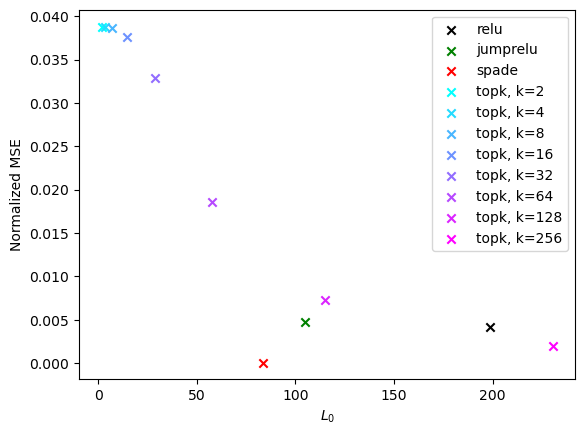

In [83]:
#scatter plot of mse vs mean of activelatentdist for all expts
colors_concepts2 = {'relu': 'k', 'jumprelu': 'green', 'sparsemax_dist': 'red'}
cmap = plt.cm.get_cmap('cool')
topk_colors2 = cmap(np.linspace(0, 1, len(kvals_topk)))
plt.figure()
for i in range(len(exptnames)):
    label = saetypes[i]
    if saetypes[i]=='topk':
        label += f", k={kvals_all[i]}"
    elif 'sparsemax_dist' in saetypes[i]:
        label = 'spade'
    plt.scatter(activelatentdist_all[i].float().mean(), mseall[i]/meannorm2_concepts_all[i].mean(), marker='x', \
        c=colors_concepts2[saetypes[i]] if saetypes[i]!='topk' else topk_colors2[kvals_topk.index(kvals_all[i])], label=label)
plt.legend()
plt.xlabel(r'$L_0$')
plt.ylabel('Normalized MSE')
# plt.xscale('log')
# plt.yscale('log')
plt.show()

In [19]:
kvals_all = torch.tensor(kvals_all)
stableranks = torch.tensor(stableranks)

In [20]:
mseconcepts = torch.stack(mseperconceptall, dim=0)

In [21]:
intrinsicdims = train_data.truefeatures['intrinsic_dims']

In [22]:
meannorm2_concepts_all = torch.stack(meannorm2_concepts_all, dim=0)

Text(0, 0.5, 'mse per concept')

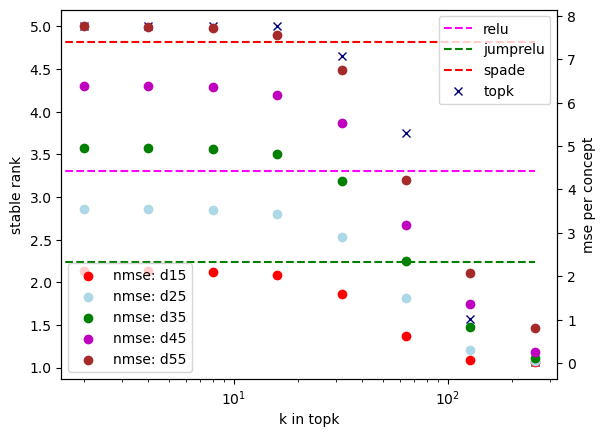

In [23]:
fig, ax = plt.subplots()

topkindices = [i for i in range(len(exptnames)) if 'topk' in exptnames[i]]

ax.hlines(stableranks[saetypes.index('relu')], 0, max(kvals_all), color='fuchsia', linestyle='dashed', label='relu')
ax.hlines(stableranks[saetypes.index('jumprelu')], 0, max(kvals_all), color='g', linestyle='dashed', label='jumprelu')
ax.hlines(stableranks[saetypes.index('sparsemax_dist')], 0, max(kvals_all), color='r', linestyle='dashed', label='spade')

ax2 = ax.twinx() 

colors_concepts = ['r','lightblue','g','m','brown']
for k in range(num_concepts):
    if k==0:
        label='mse/|x|^2'
    else:
        label=''
    ax2.scatter(kvals_all[topkindices], mseconcepts[topkindices,k], \
        label='nmse: d'+str(intrinsicdims[k].item()), color=colors_concepts[k])
ax.plot(kvals_all[topkindices], stableranks[topkindices], 'x', label='topk', color='navy')
ax.legend()
# ax2.set_yscale('log')
    


ax2.legend(loc='lower left')
ax.set_xscale('log')
ax.set_xlabel('k in topk')
ax.set_ylabel('stable rank')
ax2.set_ylabel('mse per concept')

Text(0, 0.5, 'mse/|x|^2(nmse) per concept')

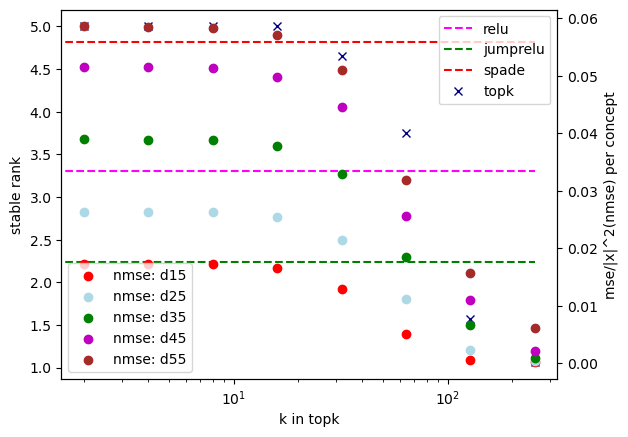

In [24]:
fig, ax = plt.subplots()

topkindices = [i for i in range(len(exptnames)) if 'topk' in exptnames[i]]

ax.hlines(stableranks[saetypes.index('relu')], 0, max(kvals_all), color='fuchsia', linestyle='dashed', label='relu')
ax.hlines(stableranks[saetypes.index('jumprelu')], 0, max(kvals_all), color='g', linestyle='dashed', label='jumprelu')
ax.hlines(stableranks[saetypes.index('sparsemax_dist')], 0, max(kvals_all), color='r', linestyle='dashed', label='spade')

ax2 = ax.twinx() 

colors_concepts = ['r','lightblue','g','m','brown']
for k in range(num_concepts):
    if k==0:
        label='mse/|x|^2'
    else:
        label=''
    ax2.scatter(kvals_all[topkindices], mseconcepts[topkindices,k]/meannorm2_concepts_all[topkindices,k], \
        label='nmse: d'+str(intrinsicdims[k].item()), color=colors_concepts[k])
ax.plot(kvals_all[topkindices], stableranks[topkindices], 'x', label='topk', color='navy')
ax.legend()
# ax2.set_yscale('log')
    


ax2.legend(loc='lower left')
ax.set_xscale('log')
ax.set_xlabel('k in topk')
ax.set_ylabel('stable rank')
ax2.set_ylabel('mse/|x|^2(nmse) per concept')

In [25]:
nontopkindices = [i for i in range(len(exptnames)) if 'topk' not in exptnames[i]]

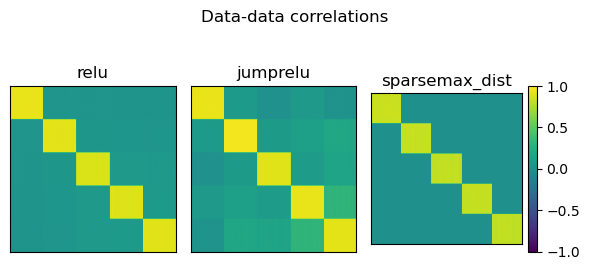

In [58]:
fig, ax = plt.subplots(1, len(nontopkindices), figsize=(6,3), sharex=True)

for i in range(len(nontopkindices)):
    temp = ax[i].imshow(Cdatacos[nontopkindices[i]].cpu(), cmap='viridis', vmin=-1, vmax=1)
    ax[i].set_title(f'{saetypes[nontopkindices[i]]}')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.colorbar(temp, ax=ax[-1], fraction=0.05, pad=0.04)
fig.suptitle("Data-data correlations")
plt.tight_layout()
plt.show()

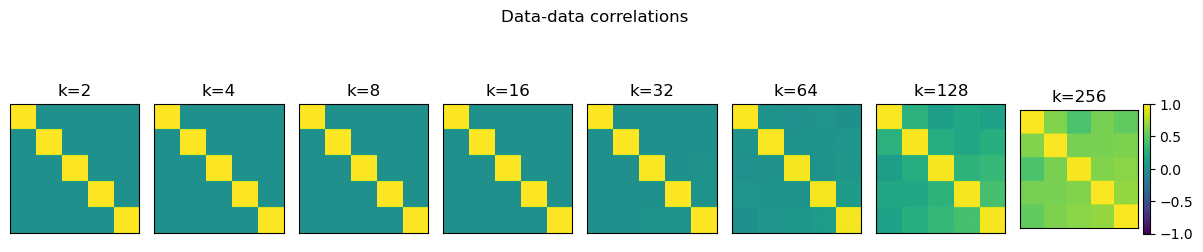

In [27]:
fig, ax = plt.subplots(1, len(topkindices), figsize=(12,3), sharex=True)

for i in range(len(topkindices)):
    kval = kvals_all[topkindices[i]]
    temp = ax[i].imshow(Cdatacos[topkindices[i]].cpu(), cmap='viridis', vmin=-1, vmax=1)
    ax[i].set_title(f'k={kval}')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.colorbar(temp, ax=ax[-1], fraction=0.05, pad=0.04)
fig.suptitle("Data-data correlations")
plt.tight_layout()
plt.show()

In [28]:
deadlatents_all = []
for i in range(len(exptnames)):
    threshold = torch.quantile(latent_reps_all[i][latent_reps_all[i]>0.0].flatten(), 0.1)
    # threshold = 1e-12
    deadlatents = torch.all(latent_reps_all[i] <= threshold, dim=0)
    deadlatents_all.append(deadlatents)


use_f1 = False
if not use_f1:
    #identify concept which latent activates most for
    classavg_reps = [torch.zeros(num_concepts, latent_reps_all[0].shape[-1]) for i in range(len(exptnames))]
    for i in range(len(exptnames)):
        for c in range(num_concepts):
            classavg_reps[i][c] = torch.mean(latent_reps_all[i][labels_subset==c], dim=0)    
    order_by_concept_all = []
    concepts_of_latents_all = []
    for i in range(len(exptnames)):
        concepts_of_latents = torch.argmax(classavg_reps[i][:, ~deadlatents_all[i]], dim=0) #gives indices of concepts with max value in each latent dimension
        order_by_concept = torch.argsort(concepts_of_latents) #sorts latents by concept
        order_by_concept_all.append(order_by_concept)
        concepts_of_latents_all.append(concepts_of_latents)
else: #need to edit this and get it to work
    #alter: sort by concept using f1 score
    eps = 1e-12
    f1_all = torch.zeros((len(exptnames), num_concepts, width))
    for i in range(len(exptnames)):
        for c in range(num_concepts):
            latents_i = latent_reps_all[i][:, ~deadlatents_all[i]] #those active
            threshold = torch.quantile(latents_i[latents_i>0.0].flatten(), 0.1) #10th percentile of data
            truepos = (latents_i[labels_subset==c,:]>threshold).sum(0).float()
            falsepos = (latents_i[labels_subset!=c,:]>threshold).sum(0).float()
            allpos = (labels_subset==c).sum().float()
            pospred = (latents_i>threshold).sum(0).float()
            precision = truepos/(pospred+eps)
            recall = truepos/(allpos+eps)
            f1 = 2*precision*recall/(precision+recall+eps)
            f1_all[i,c, :(width-deadlatents_all[i].sum())] = f1
    concepts_of_latents_all = [torch.argmax(f1_all[i,:,:], dim=0) for i in range(len(exptnames))]
    order_by_concept_all = [torch.argsort(concepts_of_latents_all[i]) for i in range(len(exptnames))]

#sort latent representations by concept
latentreps_conceptsorted_all = []
for i in range(len(exptnames)):
    activelatents = ~deadlatents_all[i]
    latentsactive = latent_reps_all[i][:, activelatents]
    latentsactive_conceptsorted = latentsactive[:, order_by_concept_all[i]]
    latentsdead = latent_reps_all[i][:, ~activelatents]
    latents_sortedanddead = torch.cat([latentsactive_conceptsorted, latentsdead], dim=1)
    latentreps_conceptsorted_all.append(latents_sortedanddead) #reorder latents by concepts

In [29]:
#track co-occurrence of latents
Clatent = []
for i in range(len(exptnames)):
    Clatent.append(latentreps_conceptsorted_all[i].T @ latentreps_conceptsorted_all[i])

Clatent_cos = []
Clatent_cos_active = []
for i in range(len(exptnames)):
    norms = torch.norm(latentreps_conceptsorted_all[i], dim=0).unsqueeze(1)
    active_i = norms>0.0
    eps = 1e-6
    Clatent_cos.append(Clatent[i]/(eps+ (norms @ norms.T)))


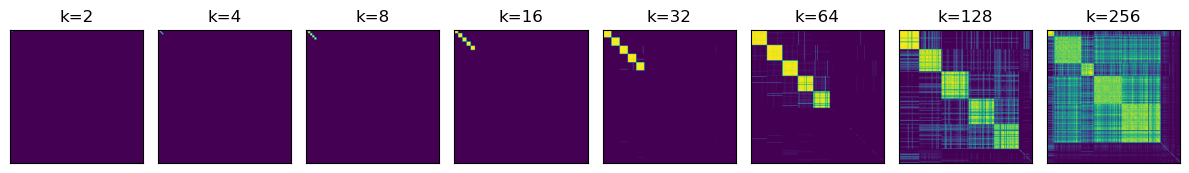

In [30]:
fig, ax = plt.subplots(1, len(topkindices), figsize=(12,3), sharex=True)

for i in range(len(topkindices)):
    kval = kvals_all[topkindices[i]]
    ax[i].imshow(Clatent_cos[topkindices[i]].cpu(), cmap='viridis', vmin=0, vmax=1)
    ax[i].set_title(f'k={kval}')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()

plt.show()

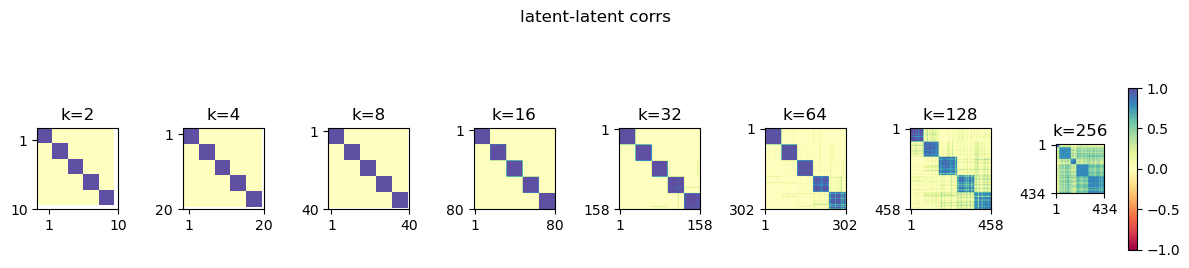

In [31]:
fig, ax = plt.subplots(1, len(topkindices), figsize=(12,3))
numactive_allk = []
for i in range(len(topkindices)):
    kval = kvals_all[topkindices[i]]
    numactive_i = (~deadlatents_all[topkindices[i]]).sum().item()
    numactive_allk.append(numactive_i)
    temp = ax[i].imshow(Clatent_cos[topkindices[i]][:numactive_i, :numactive_i].cpu(), cmap='Spectral', vmin=-1, vmax=1)
    ax[i].set_title(f'k={kval}')
    ax[i].set_xticks([1, numactive_i])
    ax[i].set_yticks([1, numactive_i])
fig.colorbar(temp, ax=ax[-1], location='right', pad=0.3, fraction=0.1)
fig.suptitle("latent-latent corrs")
fig.tight_layout()

In [32]:
nonzero_wts = []
nonzero_latents = []
for i in range(len(topkindices)):
    kvali = kvals_all[topkindices[i]]
    nonzero_latents.append(deadlatents_all[topkindices[i]].argwhere().flatten())

    expt_index = topkindices[i]
    wtsenc = modelsall[expt_index].Ae.detach().cpu()
    wtsdec = modelsall[expt_index].Ad.T.detach().cpu()
    nonzerowts_ind = (torch.sum(torch.abs(wtsenc), dim=1)>1e-6).argwhere().flatten()
    nonzero_wts.append(nonzerowts_ind)

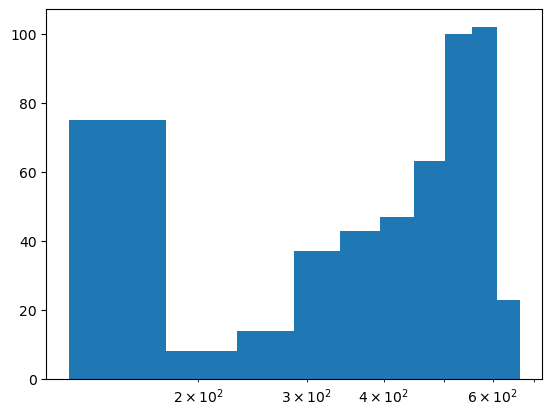

In [33]:
plt.hist(torch.sum(torch.abs(wtsenc), dim=1))
plt.xscale('log')

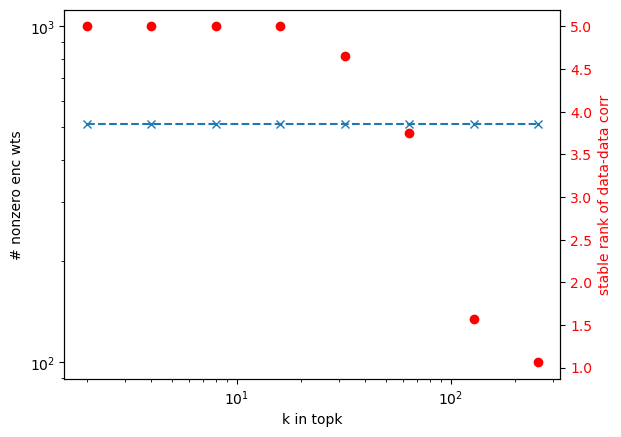

In [34]:
fig, ax = plt.subplots()
ax.plot(kvals_all[topkindices], [len(nonzero_wts[i]) for i in range(len(nonzero_wts))], 'x--')
ax2 = ax.twinx()
ax2.scatter(kvals_all[topkindices], [stableranks[topkindices[i]] for i in range(len(topkindices))], color='r')
# ax2.scatter(kvals_all[topkindices], [stableranks_wts[i] for i in range(len(topkindices))], color='g')
ax.set_xlabel("k in topk")
ax2.set_ylabel("stable rank of data-data corr", c='r')
ax2.set_yticks(ticks=[1.0+0.5*i for i in range(9)], labels=[1.0+0.5*i for i in range(9)], color='r')
ax.set_ylabel("# nonzero enc wts")
ax.set_xscale('log')
ax.set_yscale('log')

In [35]:
stableranks_wts = []
Cwts_all = []
for i in range(len(topkindices)):
    expt_index = topkindices[i]
    wts = modelsall[expt_index].Ae.detach().cpu()
    active = nonzero_wts[i]
    wtsactive = wts[active, :]
    wtsactive_sort = wtsactive[order_by_concept_all[topkindices[i]], :]
    # wtssorted = torch.cat([wtsactive_sort, wts[~active, :]], dim=0)
    wtssorted = wtsactive_sort
    norms = torch.norm(wtssorted, dim=1).unsqueeze(1)
    Cwts = wtssorted @ wtssorted.T / (1e-12+ norms@norms.T)
    Cwts_all.append(Cwts)
    sr = stable_rank(Cwts)
    stableranks_wts.append(sr)

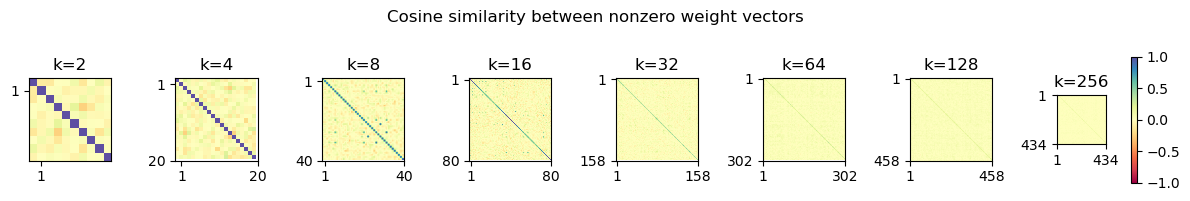

In [36]:
fig, ax = plt.subplots(1, len(topkindices), figsize=(12,2))

for i in range(len(topkindices)):
    ax[i].imshow(Cwts_all[i].cpu(), cmap='Spectral', vmin=-1, vmax=1)
    ax[i].set_title(f'k={kvals_all[topkindices[i]]}')
    ax[i].set_yticks([1, Cwts_all[i].shape[0]])
    ax[i].set_xticks([1, Cwts_all[i].shape[0]])
#add 1 colorbar for entire fig
fig.colorbar(ax[0].imshow(Cwts_all[0].cpu(), cmap='Spectral', vmin=-1, vmax=1), ax=ax[-1], location='right', pad=0.3, fraction=0.1)
fig.suptitle("Cosine similarity between nonzero weight vectors")
fig.tight_layout()

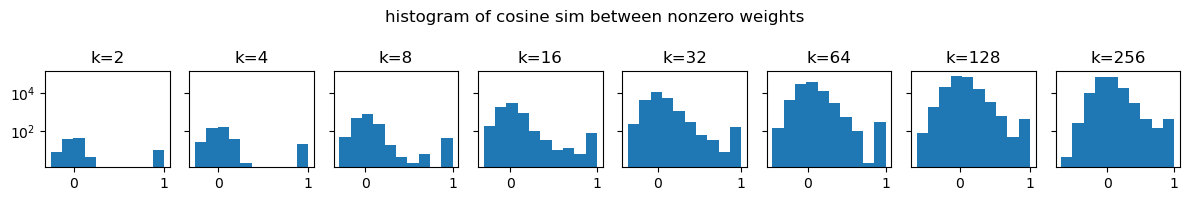

In [37]:
fig, ax = plt.subplots(1, len(topkindices), figsize=(12,2), sharey=True)

for i in range(len(topkindices)):
    ax[i].hist(Cwts_all[i].flatten())
    ax[i].set_yscale('log')
    ax[i].set_title(f'k={kvals_all[topkindices[i]]}')
fig.suptitle("histogram of cosine sim between nonzero weights")
fig.tight_layout()

In [38]:
numactive = torch.zeros(len(exptnames), len(labels_subset))
for i in range(len(exptnames)):
    threshold = torch.quantile(latent_reps_all[i][latent_reps_all[i]>1e-6].flatten(),0.1)
    numactive[i] = (latent_reps_all[i]>threshold).sum(dim=1)

In [39]:
numactive_topk = numactive[3:]

In [40]:
numactive_concepts = []
for i in range(len(exptnames)):
    numactive_concepts.append(torch.stack([numactive[i][labels_subset==j].mean() for j in range(num_concepts)]))

In [41]:
numactive_concepts = torch.stack(numactive_concepts, dim=0)

In [42]:
conceptsortorder = torch.argsort(concept_intrinsicdims)

Text(0.5, 1.0, 'number of active latents')

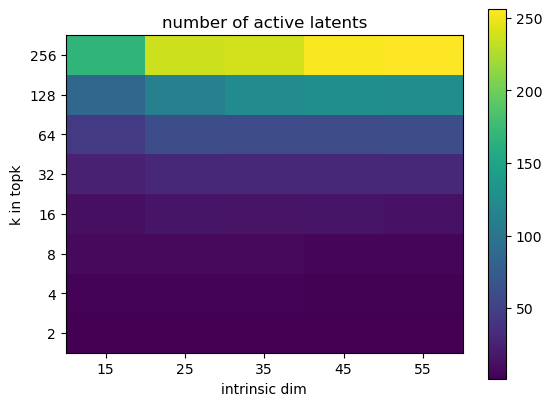

In [43]:
numactive_concepts_sort = numactive_concepts[:, conceptsortorder]
plt.imshow(numactive_concepts_sort[topkindices,:], cmap='viridis', aspect=0.5,interpolation='nearest', origin='lower')
plt.xticks(range(len(intrinsicdims)), intrinsicdims[conceptsortorder].tolist())
plt.yticks(range(len(kvals_topk)), torch.tensor(kvals_topk).tolist())
plt.xlabel("intrinsic dim")
plt.ylabel("k in topk")
plt.colorbar()
plt.title("number of active latents")

Text(0, 0.5, '# active latents')

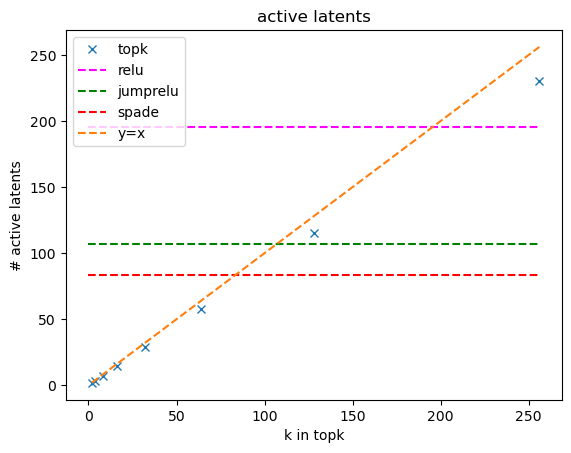

In [44]:
plt.plot(kvals_all[topkindices], numactive[topkindices,:].mean(dim=1), 'x', label='topk')
plt.hlines(numactive[saetypes.index('relu'),:].mean(), 0, max(kvals_all), color='fuchsia', linestyle='dashed', label='relu')
plt.hlines(numactive[saetypes.index('jumprelu'),:].mean(), 0, max(kvals_all), color='g', linestyle='dashed', label='jumprelu')
plt.hlines(numactive[saetypes.index('sparsemax_dist'),:].mean(), 0, max(kvals_all), color='r', linestyle='dashed', label='spade')
plt.plot(kvals_all[topkindices], kvals_all[topkindices], '--', label="y=x")
plt.legend()
plt.title("active latents")
plt.xlabel("k in topk")
plt.ylabel("# active latents")

In [45]:
var_concepts = []
mean_concepts = torch.zeros((num_concepts, dim))
for k in range(num_concepts):
    var_concepts.append(torch.var(data_subset[labels_subset==k,:], dim=0).sum())
    mean_concepts[k,:] = torch.mean(data_subset[labels_subset==k,:], dim=0)

In [46]:
var_concepts

[tensor(2.1745),
 tensor(3.5464),
 tensor(5.0126),
 tensor(6.3835),
 tensor(7.9245)]

In [47]:
mse_meanconc_all = []
for i in range(len(exptnames)):
    mse_meanconc = torch.stack([torch.mean((preds_all[i][labels_subset==j,:]-mean_concepts[j,:])**2) for j in range(num_concepts)])
    mse_meanconc_all.append(mse_meanconc)

In [48]:
mseperconceptall

[tensor([0.1771, 0.2702, 0.3878, 0.5235, 1.3281]),
 tensor([0.2494, 0.3443, 0.6398, 0.7553, 1.0185]),
 tensor([0.0012, 0.0038, 0.0074, 0.0150, 0.0214]),
 tensor([2.1153, 3.5408, 4.9557, 6.3911, 7.7560]),
 tensor([2.1116, 3.5367, 4.9472, 6.3821, 7.7453]),
 tensor([2.1052, 3.5285, 4.9323, 6.3648, 7.7230]),
 tensor([2.0297, 3.4272, 4.8095, 6.1817, 7.5649]),
 tensor([1.5834, 2.8917, 4.1874, 5.5218, 6.7588]),
 tensor([0.6226, 1.5074, 2.3582, 3.1750, 4.2135]),
 tensor([0.0723, 0.2953, 0.8396, 1.3548, 2.0774]),
 tensor([0.0156, 0.0444, 0.1166, 0.2542, 0.8118])]

Text(0.5, 1.0, 'MSE wrt mean of cluster')

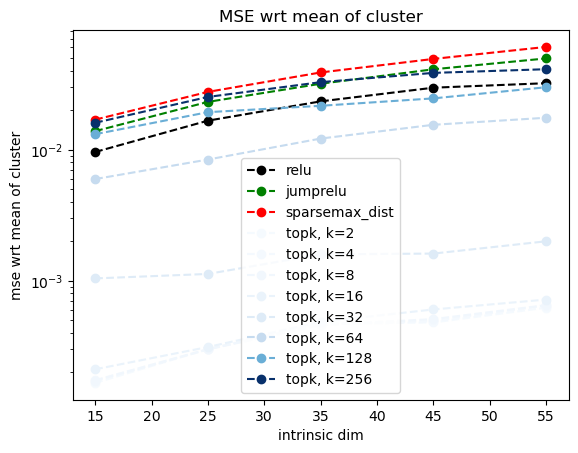

In [49]:
colors = {'relu': 'k', 'jumprelu': 'green', 'sparsemax_dist': 'red'}
cmap = plt.get_cmap('Blues')

topk_colors = [cmap(k / max(kvals_all)) for k in kvals_topk]

for i in range(len(exptnames)):
    label = saetypes[i]
    if 'topk' in exptnames[i]:
        label += f", k={kvals_all[i]}"
    plt.plot(concept_intrinsicdims, mse_meanconc_all[i], 'o--', label=label, c=colors[saetypes[i]] if saetypes[i] in colors else topk_colors[kvals_topk.index(kvals_all[i])])
plt.xlabel('intrinsic dim')
plt.yscale('log')
plt.legend()
plt.ylabel('mse wrt mean of cluster')
plt.title("MSE wrt mean of cluster")

Text(0.5, 1.0, 'MSE')

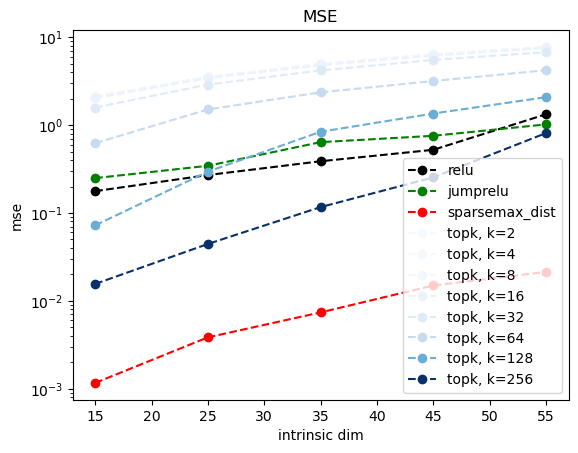

In [50]:
colors = {'relu': 'k', 'jumprelu': 'green', 'sparsemax_dist': 'red'}
cmap = plt.get_cmap('Blues')

topk_colors = [cmap(k / max(kvals_all)) for k in kvals_topk]

for i in range(len(exptnames)):
    label = saetypes[i]
    if 'topk' in exptnames[i]:
        label += f", k={kvals_all[i]}"
    plt.plot(concept_intrinsicdims, mseperconceptall[i], 'o--', label=label, c=colors[saetypes[i]] if saetypes[i] in colors else topk_colors[kvals_topk.index(kvals_all[i])])
plt.xlabel('intrinsic dim')
plt.yscale('log')
plt.legend()
plt.ylabel('mse')
plt.title("MSE")

In [51]:
#for each sae, find cosine sim between each model.Ae vector and mean_concepts
coswts_meanconc = []
dotwts_meanconc = []
for i in range(len(exptnames)):
    wts = modelsall[i].Ae.detach().cpu()
    #sort wts according to order_by_concept_all
    wtsactive = wts[~deadlatents_all[i], :]
    wtsdead = wts[deadlatents_all[i], :]
    wtsactive = wtsactive[order_by_concept_all[i], :]
    wts = torch.cat([wtsactive, wtsdead], dim=0)
    # wts = wtsactive
    # normalize wts and mean_concepts and find cos sim
    norms_wts = torch.norm(wts, dim=1).unsqueeze(1)
    norms_meanconc = torch.norm(mean_concepts, dim=1).unsqueeze(1)
    coswts_meanconc_i = wts @ mean_concepts.T / (1e-12 + norms_wts @ norms_meanconc.T)
    dot_meanconc_i = wts @ mean_concepts.T
    dotwts_meanconc.append(dot_meanconc_i)
    coswts_meanconc.append(coswts_meanconc_i)

In [52]:
dotwts_meanconc = torch.stack(dotwts_meanconc, dim=0)
coswts_meanconc = torch.stack(coswts_meanconc, dim=0)

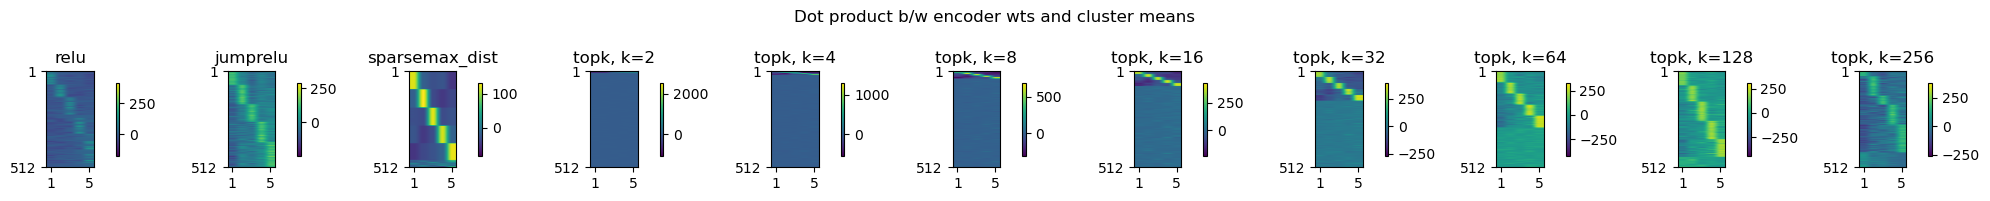

In [53]:
#plot coswts_meanconc as imshow for all expts, name each plot with saetype and use k if topk
fig, ax = plt.subplots(1, len(exptnames), figsize=(20,2))
for i in range(len(exptnames)):
    numactive = (~deadlatents_all[i]).sum().item()
    temp = ax[i].imshow(dotwts_meanconc[i], cmap='viridis', aspect='auto')#0.01*numactive/width)
    title = f"{saetypes[i]}"
    if 'topk' in exptnames[i]:
        title += f", k={kvals_all[i]}"
    ax[i].set_title(title)
    ax[i].set_xticks(ticks=[0, num_concepts-1], labels=[1, num_concepts])
    ax[i].set_yticks(ticks = [0, width-1], labels=[1, width])
    fig.colorbar(temp, ax= ax[i], location='right', pad=0.3, fraction=0.05)

fig.suptitle("Dot product b/w encoder wts and cluster means")
fig.tight_layout()

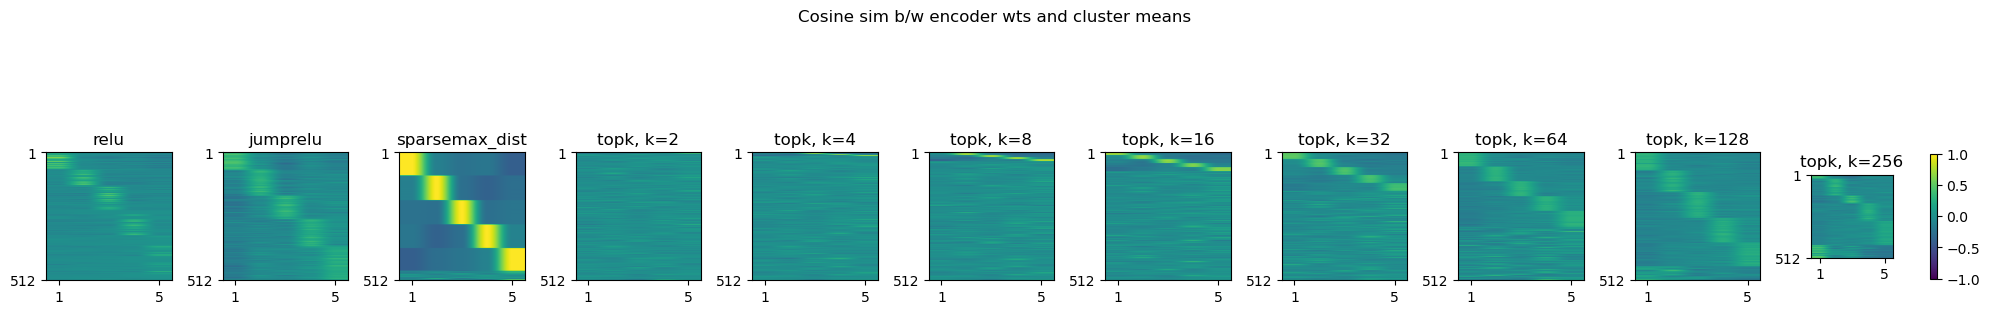

In [54]:
#plot coswts_meanconc as imshow for all expts, name each plot with saetype and use k if topk
fig, ax = plt.subplots(1, len(exptnames), figsize=(20,4))
for i in range(len(exptnames)):
    numactive = (~deadlatents_all[i]).sum().item()
    temp = ax[i].imshow(coswts_meanconc[i], cmap='viridis', vmin=-1, vmax=1, aspect=0.01)#0.01*numactive/width)
    title = f"{saetypes[i]}"
    if 'topk' in exptnames[i]:
        title += f", k={kvals_all[i]}"
    ax[i].set_title(title)
    ax[i].set_xticks(ticks=[0, num_concepts-1], labels=[1, num_concepts])
    ax[i].set_yticks(ticks = [0, width-1], labels=[1, width])
fig.colorbar(temp, ax = ax[-1], location='right', pad=0.3, fraction=0.05)
fig.suptitle("Cosine sim b/w encoder wts and cluster means")
fig.tight_layout()